The main objective of this project is to work on customer segmentation dataset and find labels to identify what proportion of customers belong to which label. Further analyse which label belong to churning and not churning customers.

Here, the number of clusters (`n_clusters`) will be 2.

The customer segmentation dataset consists of more than 50,000 rows and 8 columns. I will use clustering algorithms of `KMeans`, `KMeans` with `PCA` and `DBSCAN`.

The steps involved in this project are:

* Importing necessary libraries
* Data cleaning
* Exploratory data analysis
* Visualization of raw data
* Performing `KMeans` clustering
* Performing `AgglomerativeClustering`
* Performing `KMeans` with `PCA`
* Performing `DBSCAN`
* Visualizing output obtained from above mentioned algorithms
* Comparing results
* Identifying which label belongs to customer leaving or staying

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

## Importing dataset

In [5]:
initial_df = pd.read_excel('/content/customer_segmentation.xlsx')

In [6]:
initial_df.shape

(541909, 8)

In [7]:
# reducing the size of dataset for faster computation
initial_df = initial_df.sample(n = 15000, random_state = 42)

In [8]:
initial_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
209268,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom
207108,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom
167085,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom
471836,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom
115865,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom


In [9]:
initial_df.shape

(15000, 8)

## Data cleaning and manipulation

In [10]:
# making column names standard
col_names = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
initial_df.columns = col_names

In [11]:
initial_df.shape

(15000, 8)

In [12]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 209268 to 273817
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    15000 non-null  object        
 1   stock_code    15000 non-null  object        
 2   description   14953 non-null  object        
 3   quantity      15000 non-null  int64         
 4   invoice_date  15000 non-null  datetime64[ns]
 5   unit_price    15000 non-null  float64       
 6   customer_id   11179 non-null  float64       
 7   country       15000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.0+ MB


In [13]:
# finding null values
initial_df.isna().sum()

,0
invoice_no,0
stock_code,0
description,47
quantity,0
invoice_date,0
unit_price,0
customer_id,3821
country,0


In [14]:
# removing null values
initial_df.dropna(subset = ['customer_id'], inplace = True)
initial_df.isna().sum()

,0
invoice_no,0
stock_code,0
description,0
quantity,0
invoice_date,0
unit_price,0
customer_id,0
country,0


In [15]:
# finding number of unique values in each column
for col in initial_df.columns:
  print(f'{col}: {initial_df[col].nunique()}')

invoice_no: 7087
stock_code: 2333
description: 2383
quantity: 107
invoice_date: 6932
unit_price: 166
customer_id: 2830
country: 34


In [16]:
# removing duplicates while keeping first occurence
new_df = initial_df.drop_duplicates(keep = 'first')
print(f'Number of rows in new_df: {new_df.shape[0]}')
print(f'Number of rows in initial_df: {initial_df.shape[0]}')
print(f'Number of duplicate rows: {initial_df.shape[0] - new_df.shape[0]}')

Number of rows in new_df: 11176
Number of rows in initial_df: 11179
Number of duplicate rows: 3


In [17]:
# dropping invoice_no column as it is not needed for further analysis
new_df = new_df.copy()
new_df.drop('invoice_no', inplace = True, axis = 1)

In [18]:
# creating a new column 'total_price'
new_df = new_df.copy()
new_df['total_price'] = new_df['quantity'] * new_df['unit_price']
new_df.head()

,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price
209268,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,20.40
207108,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,27.80
167085,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,2.60
471836,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom,5.85
115865,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom,19.90


In [19]:
# checking for negative values in 'quantity' and 'unit_price'
remove_df = new_df.loc[(new_df['quantity'] < 0) | (new_df['unit_price'] < 0)]
remove_df.head()

,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price
414833,22465,HANGING METAL STAR LANTERN,-5,2011-10-24 13:59:00,1.65,17119.0,United Kingdom,-8.25
121072,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-1,2011-03-16 11:39:00,4.95,18183.0,United Kingdom,-4.95
250423,84857C,PINK MONTE CARLO HANDBAG,-1,2011-07-05 14:51:00,1.95,16571.0,United Kingdom,-1.95
492655,22697,GREEN REGENCY TEACUP AND SAUCER,-3,2011-11-23 11:06:00,2.95,16201.0,United Kingdom,-8.85
159710,M,Manual,-1,2011-04-18 10:29:00,222.75,13811.0,Germany,-222.75


In [20]:
# removing rows with negative values in 'quantity' or 'unit_price'
new_df = new_df.copy()
new_df.drop(remove_df.index, inplace = True)
new_df.reset_index(drop = True, inplace = True)
new_df.shape

(10926, 8)

In [21]:
print(new_df['invoice_date'].dtype)

datetime64[ns]


In [22]:
# changing datatype of 'invoice_date' to create new columns of day_name, month and year
new_df = new_df.copy()
new_df['invoice_date'] = pd.to_datetime(new_df['invoice_date'], errors = 'coerce')
print(new_df['invoice_date'].dtype)

datetime64[ns]


In [23]:
new_df['weekday'] = new_df['invoice_date'].dt.day_name()
new_df['month'] = new_df['invoice_date'].dt.month_name()
new_df['year'] = new_df['invoice_date'].dt.year
new_df['hour'] = new_df['invoice_date'].dt.hour

In [24]:
new_df.head()

,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,total_price,weekday,month,year,hour
0,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,20.40,Wednesday,June,2011,12
1,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,27.80,Friday,May,2011,17
2,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,2.60,Thursday,April,2011,17
3,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom,5.85,Wednesday,November,2011,10
4,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom,19.90,Thursday,March,2011,8


In [25]:
new_df['hour'].unique()

array([12, 17, 10,  8, 15, 13, 16,  9, 14, 11, 18, 19, 20,  7],
      dtype=int32)

In [26]:
new_df['hour'] = new_df['hour'].astype('int')

In [27]:
# creating new column 'day_time' based on time of purchasing
new_df.loc[new_df['hour'] < 12, 'day_time'] = 'morning'
new_df.loc[(new_df['hour'] >= 12) & (new_df['hour'] < 17), 'day_time'] = 'afternoon'
new_df.loc[new_df['hour'] >= 17, 'day_time'] = 'evening'

In [28]:
# removing unwanted columns
new_df.drop(['invoice_date', 'hour'], inplace = True, axis = 1)
new_df.head()

,stock_code,description,quantity,unit_price,customer_id,country,total_price,weekday,month,year,day_time
0,71459,HANGING JAM JAR T-LIGHT HOLDER,24,0.85,17315.0,United Kingdom,20.40,Wednesday,June,2011,afternoon
1,21128,GOLD FISHING GNOME,4,6.95,14031.0,United Kingdom,27.80,Friday,May,2011,evening
2,21086,SET/6 RED SPOTTY PAPER CUPS,4,0.65,14031.0,United Kingdom,2.60,Thursday,April,2011,evening
3,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,1.95,17198.0,United Kingdom,5.85,Wednesday,November,2011,morning
4,22180,RETROSPOT LAMP,2,9.95,13502.0,United Kingdom,19.90,Thursday,March,2011,morning


In [29]:
# dropping 'customer_id'
final_df = new_df.copy()
final_df.drop('customer_id', inplace = True, axis = 1)
final_df.head()

,stock_code,description,quantity,unit_price,country,total_price,weekday,month,year,day_time
0,71459,HANGING JAM JAR T-LIGHT HOLDER,24,0.85,United Kingdom,20.40,Wednesday,June,2011,afternoon
1,21128,GOLD FISHING GNOME,4,6.95,United Kingdom,27.80,Friday,May,2011,evening
2,21086,SET/6 RED SPOTTY PAPER CUPS,4,0.65,United Kingdom,2.60,Thursday,April,2011,evening
3,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,1.95,United Kingdom,5.85,Wednesday,November,2011,morning
4,22180,RETROSPOT LAMP,2,9.95,United Kingdom,19.90,Thursday,March,2011,morning


In [30]:
final_df.dtypes

,0
stock_code,object
description,object
quantity,int64
unit_price,float64
country,object
total_price,float64
weekday,object
month,object
year,int32
day_time,object


In [31]:
final_df.year = final_df.year.astype('object')
final_df.dtypes

,0
stock_code,object
description,object
quantity,int64
unit_price,float64
country,object
total_price,float64
weekday,object
month,object
year,object
day_time,object


## Exploratory Data Analysis

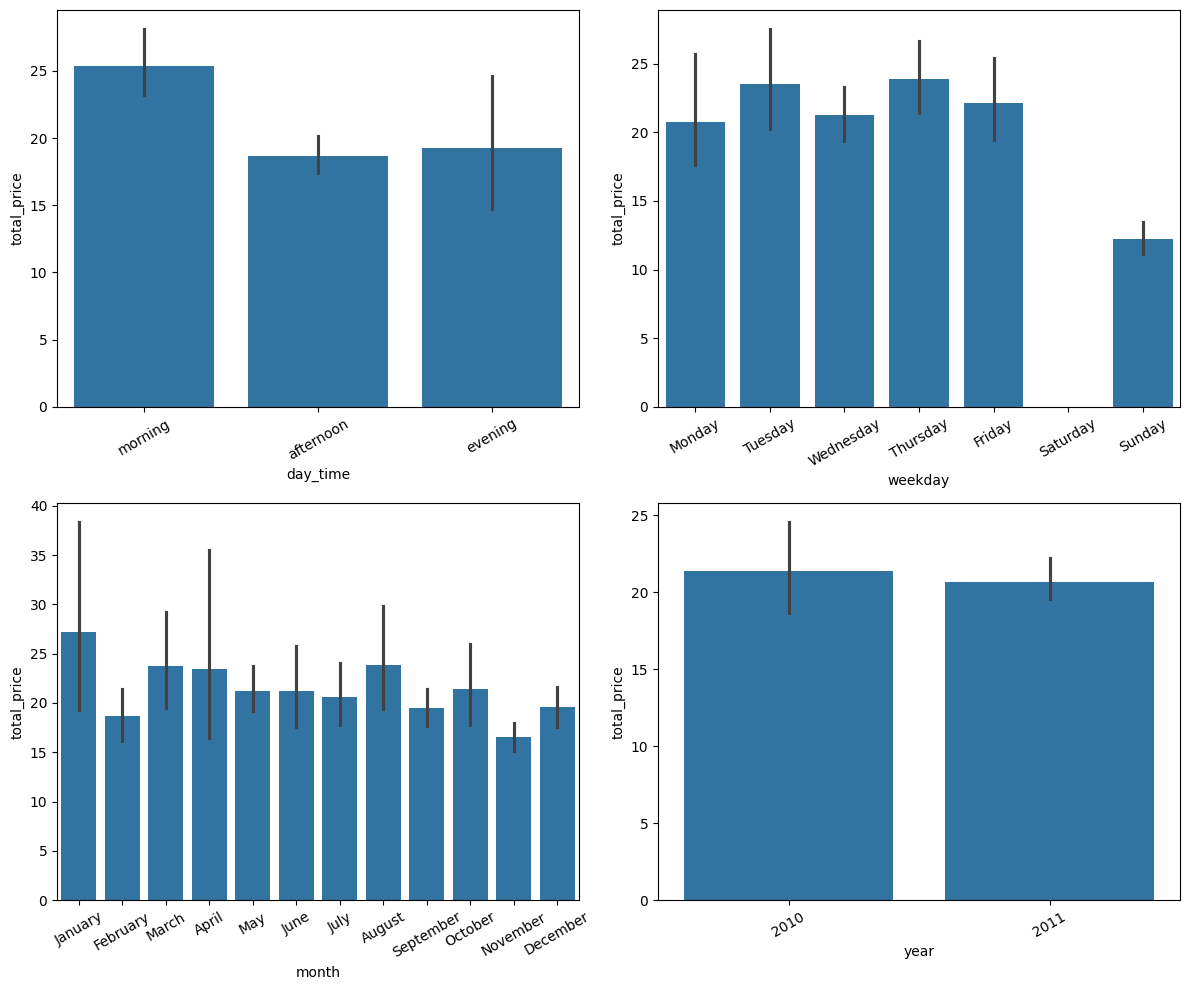

In [32]:
# total price spending per weekday, month, year and day time
fig, ax = plt.subplots(2,2, figsize = (12,10))
daytime = ['morning', 'afternoon', 'evening']
wkday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
year = [2010, 2011]

sns.barplot(x = 'day_time', y = 'total_price', data = final_df, order = daytime, ax = ax[0,0])

sns.barplot(x = 'weekday', y = 'total_price', data = final_df, order = wkday, ax = ax[0,1])

sns.barplot(x = 'month', y = 'total_price', data = final_df, order = month, ax = ax[1,0])

sns.barplot(x = 'year', y = 'total_price', data = final_df, order = year, ax = ax[1,1])

ax[0,0].set_xticks(range(len(daytime)))
ax[0,0].set_xticklabels(daytime, rotation=30)

ax[0,1].set_xticks(range(len(wkday)))
ax[0,1].set_xticklabels(wkday, rotation=30)

ax[1,0].set_xticks(range(len(month)))
ax[1,0].set_xticklabels(month, rotation=30)

ax[1,1].set_xticks(range(len(year)))
ax[1,1].set_xticklabels(year, rotation=30)

plt.tight_layout()
plt.show()

Based on the graphs above, we can conclude:

* The majority of high-value purchases occurred in the morning.
* Tuesdays and Thursdays had nearly identical high-price purchase patterns.
* In terms of months, January showed hightest purchasing.
* There was little difference in total spending between 2010 and 2011.

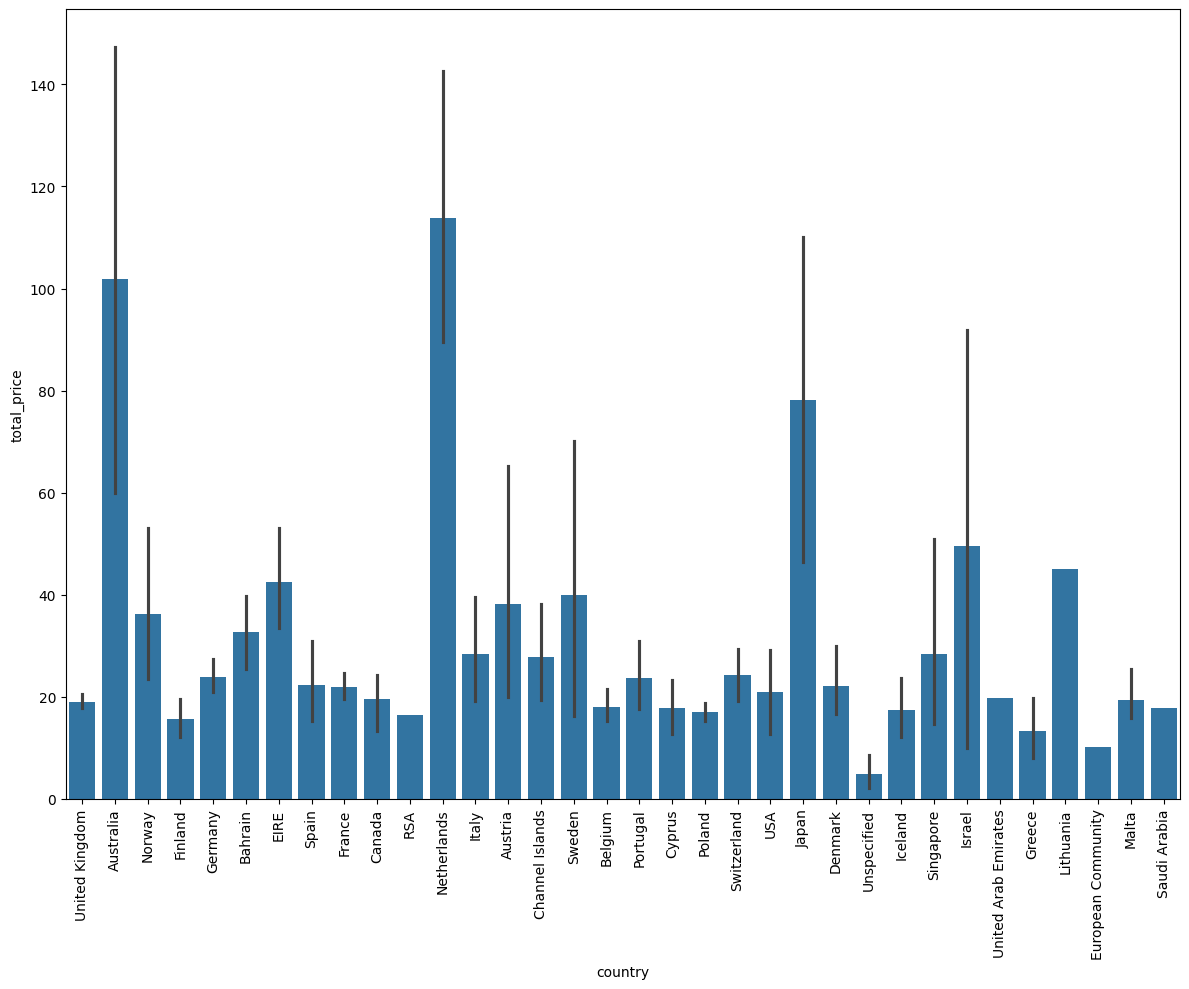

In [33]:
# let us now check how the total price is distributed over different countries
fig, ax = plt.subplots(figsize = (12,10))
sns.barplot(x = 'country', y = 'total_price', data = final_df, ax = ax)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

Among the countries with the highest total spending, the Netherlands and Australia stand out, with the Netherlands being the top spender.

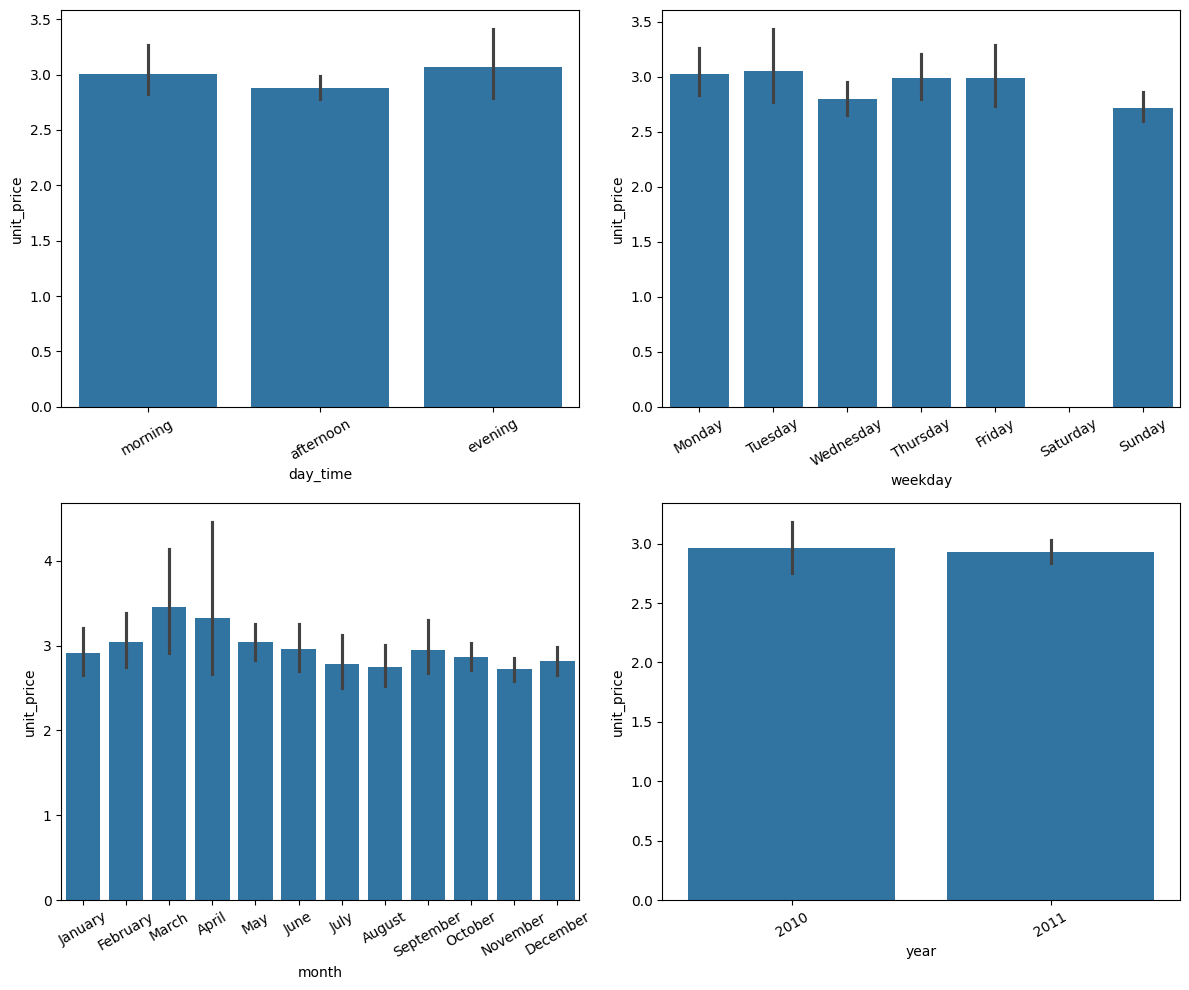

In [34]:
# let us now visualize the number of units sold in day_time, weekday, month and year
fig, ax = plt.subplots(2,2, figsize = (12,10))
sns.barplot(x = 'day_time', y = 'unit_price', data = final_df, order = daytime, ax = ax[0,0])
sns.barplot(x = 'weekday', y = 'unit_price', data = final_df, order = wkday, ax = ax[0,1])
sns.barplot(x = 'month', y = 'unit_price', data = final_df, order = month, ax = ax[1,0])
sns.barplot(x = 'year', y = 'unit_price', data = final_df, order = year, ax = ax[1,1])

ax[0,0].set_xticks(range(len(daytime)))
ax[0,0].set_xticklabels(daytime, rotation=30)

ax[0,1].set_xticks(range(len(wkday)))
ax[0,1].set_xticklabels(wkday, rotation=30)

ax[1,0].set_xticks(range(len(month)))
ax[1,0].set_xticklabels(month, rotation=30)

ax[1,1].set_xticks(range(len(year)))
ax[1,1].set_xticklabels(year, rotation=30)

plt.tight_layout()
plt.show()

Based on the total number of units sold, there was no significant difference between time of the day, weekdays and year. However, sales in March showed slightly higher compared to other months.

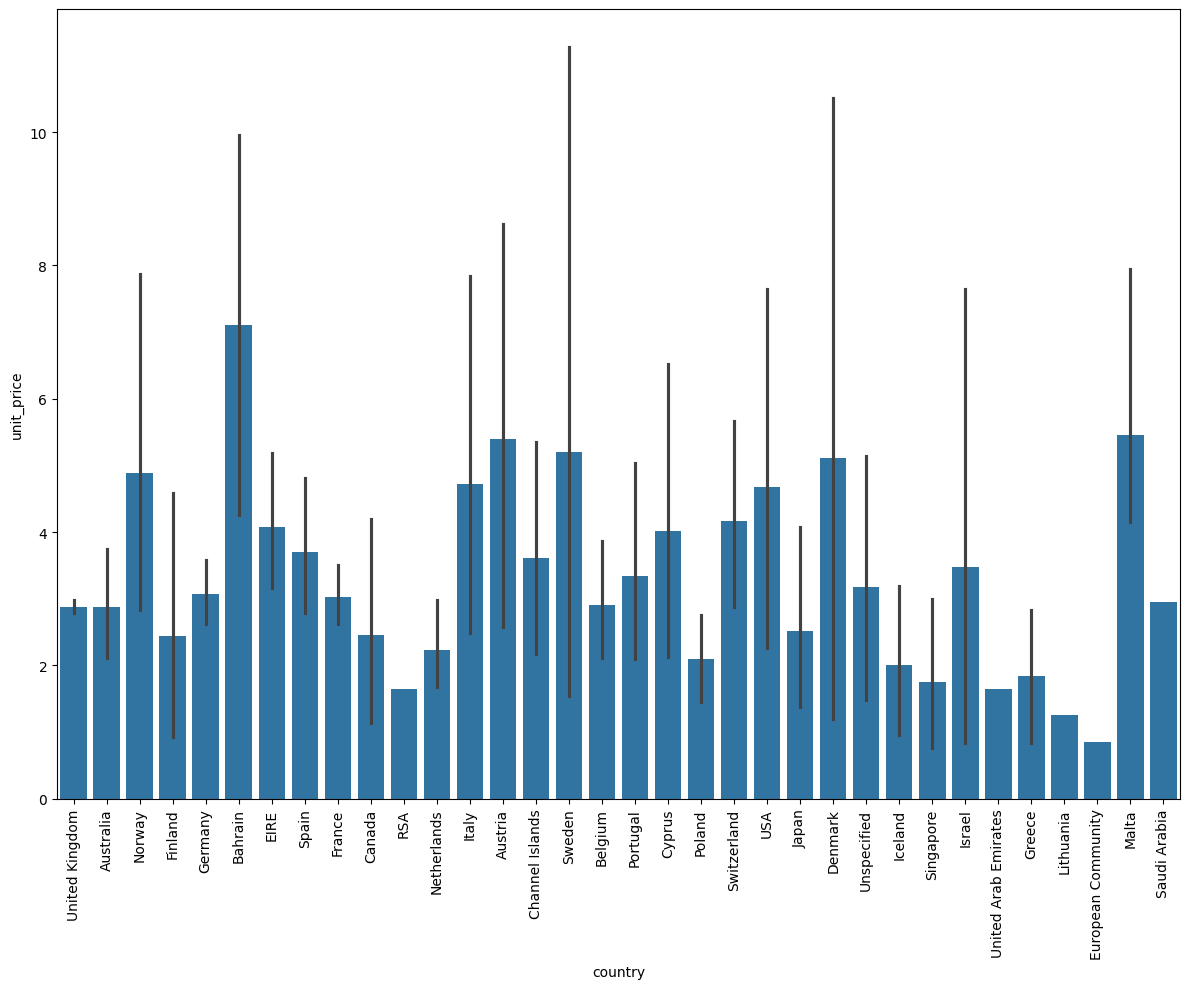

In [35]:
# let us now visualize total number of units sold as per different countries
fig, ax = plt.subplots(figsize = (12,10))
sns.barplot(x = 'country', y = 'unit_price', data = final_df, ax = ax)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

## Unsupervised learning algorithms

In [36]:
# we use label encoding to convert categorical data into numerical.
cat_features = final_df.select_dtypes(include = 'object').columns
cat_features

Index(['stock_code', 'description', 'country', 'weekday', 'month', 'year',
       'day_time'],
      dtype='object')

In [39]:
for col in cat_features:
    le = LabelEncoder()
    final_df[col] = final_df[col].astype(str)  # convert everything to string
    final_df[col] = le.fit_transform(final_df[col])


In [40]:
final_df.head()

,stock_code,description,quantity,unit_price,country,total_price,weekday,month,year,day_time
0,1940,945,24,0.85,32,20.40,5,6,1,0
1,214,881,4,6.95,32,27.80,0,8,1,1
2,192,1931,4,0.65,32,2.60,3,0,1,1
3,1238,1330,3,1.95,32,5.85,5,9,1,2
4,731,1688,2,9.95,32,19.90,3,7,1,2


In [41]:
scale = MinMaxScaler()
scaled_df = scale.fit_transform(final_df)

scaled_df = pd.DataFrame(scaled_df, columns = final_df.columns)
scaled_df.describe()

,stock_code,description,quantity,unit_price,country,total_price,weekday,month,year,day_time
count,10926.000000,10926.000000,10926.000000,10926.000000,10926.000000,10926.000000,10926.000000,10926.000000,10926.000000,10926.000000
mean,0.489806,0.512147,0.004072,0.009482,0.906417,0.006136,0.523321,0.567212,0.933553,0.328528
std,0.270124,0.280454,0.016773,0.016476,0.193001,0.019240,0.332110,0.321836,0.249073,0.454623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.266839,0.281910,0.000347,0.004048,0.969697,0.001464,0.200000,0.272727,1.000000,0.000000
50%,0.485967,0.502113,0.001737,0.006314,0.969697,0.003683,0.600000,0.636364,1.000000,0.000000
75%,0.700777,0.745139,0.003821,0.012143,0.969697,0.005858,0.800000,0.818182,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## KMeans clustering

In [42]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
kmeans.fit(scaled_df)

centroids = kmeans.cluster_centers_
label_kmeans = kmeans.labels_

In [44]:
# creating new dataframe to see clusters for different models
df = new_df['customer_id'].copy().to_frame()
df['cluster_kmeans'] = label_kmeans
df.groupby('customer_id').first()

,cluster_kmeans
customer_id,
12347.0,2
12349.0,1
12353.0,1
12354.0,2
12355.0,0
...,...
18270.0,0
18272.0,1
18282.0,0


## Hierarchical Clustering

In [45]:
agg = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')

agg.fit(scaled_df)
label_agg = agg.labels_

In [46]:
df['cluster_agg'] = label_agg
df.head()

,customer_id,cluster_kmeans,cluster_agg
0,17315.0,2,0
1,14031.0,0,1
2,14031.0,1,1
3,17198.0,1,1
4,13502.0,1,1


## KMeans with PCA

In [47]:
# since we have too many features, we can apply PCA before applying KMeans
pca = PCA(n_components = 3)
pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(pca.transform(scaled_df), columns = ['PC1', 'PC2', 'PC3'])
pca.explained_variance_ratio_

array([0.30807712, 0.17569208, 0.16201226])

In [48]:
kmeans.fit_transform(pca_df)

centroid_pca_kmeans = kmeans.cluster_centers_
label_pca_kmeans = kmeans.labels_

In [49]:
df = df.copy()
df['cluster_pca_kmeans'] = label_pca_kmeans
df.groupby('customer_id').first()

,cluster_kmeans,cluster_agg,cluster_pca_kmeans
customer_id,,,
12347.0,2,0,1
12349.0,1,1,0
12353.0,1,1,2
12354.0,2,0,1
12355.0,0,0,1
...,...,...,...
18270.0,0,0,1
18272.0,1,1,2
18282.0,0,0,1


## DBSCAN clustering

In [50]:
dbscan = DBSCAN(eps = 0.5, min_samples = 5)
dbscan.fit(scaled_df)

label_dbscan = dbscan.labels_

In [51]:
df = df.copy()
df['cluster_dbscan'] = label_dbscan
df.groupby('customer_id').first()

,cluster_kmeans,cluster_agg,cluster_pca_kmeans,cluster_dbscan
customer_id,,,,
12347.0,2,0,1,0
12349.0,1,1,0,0
12353.0,1,1,2,0
12354.0,2,0,1,0
12355.0,0,0,1,0
...,...,...,...,...
18270.0,0,0,1,0
18272.0,1,1,2,0
18282.0,0,0,1,0


In [52]:
# number of clusters formed in DBSCAN
df['cluster_dbscan'].nunique()

5

In [53]:
noise = df['cluster_dbscan'] != -1

In [54]:
# checking the quality of clustering
score_kmeans = silhouette_score(scaled_df, label_kmeans)
score_agg = silhouette_score(scaled_df, label_agg)
score_kmeans_pca = silhouette_score(pca_df, label_pca_kmeans)
score_dbscan = silhouette_score(scaled_df[noise], label_dbscan[noise])

In [55]:
score_dbscan

np.float64(0.22153580262711475)

In [56]:
score_df = pd.DataFrame([{
    'kmeans': score_kmeans,
    'agg': score_agg,
    'kmeans_pca': score_kmeans_pca,
    'dbscan': score_dbscan
}])

score_df

,kmeans,agg,kmeans_pca,dbscan
0,0.203089,0.323815,0.39929,0.221536


From the above data, we can see that all the clustering algorithms give medium score, which means that the clustering is somewhat meaningful.

When comparing with all the models, we `KMeans` with `PCA` gives better results followed by `AgglomerativeClustering`.

We can increase the efficiency of clustering by identifying optimal value of `n_clusters` in all the models.

We can also use `pca_df` for `AgglomerativeClustering` and `DBSCAN` to check for better clustering.